In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

#miscelaneous
from google.colab import files

The code cell below will download the weights for the model trained in Task 1

In [2]:
# Download pre-trained weights from part 1 (attempt 8)
!gdown 12LQ-GVdlMLDK-xmZSkTrtfgVCnEV2AQt

Downloading...
From (original): https://drive.google.com/uc?id=12LQ-GVdlMLDK-xmZSkTrtfgVCnEV2AQt
From (redirected): https://drive.google.com/uc?id=12LQ-GVdlMLDK-xmZSkTrtfgVCnEV2AQt&confirm=t&uuid=8acae087-61c0-455e-9003-f7d8459370ca
To: /content/attempt8.tar
100% 256M/256M [00:03<00:00, 70.2MB/s]


Download datset 2 and 3 (6k images each)

In [ ]:
# Download dataset 2 and 3 (prostate cancer and animal faces)
if not os.path.exists("Dataset_2.zip"):
  !gdown 1cv4i5bSuGUgxGam73D_JnAN2G4XtSFWf
  !unzip Dataset_2.zip
else:
  print("The dataset 2 has already been downloaded. Skipping this step.")

if not os.path.exists("Dataset_3.zip"):
  !gdown 1flt1M8ME-5oKoZ5M3etK3Zal67FVxSJo
  !unzip Dataset_3.zip
else:
  print("The dataset 3 has already been downloaded. Skipping this step.")

Download samples (100 images) for dataset 2 and dataset 3

In [3]:
# Download dataset 2 and 3 (prostate cancer and animal faces) samples
if not os.path.exists("prostate_cancer_sample.zip"):
  !gdown 1YW4jufX8l3dsBv4ivsh8enMWEWH_LgxV
  !unzip prostate_cancer_sample.zip
else:
  print("The dataset 2 sample has already been downloaded. Skipping this step.")

if not os.path.exists("animal_faces_sample.zip"):
  !gdown 1fuYVyOst7HZq4uTj46Gc2JU6nBguiLIF
  !unzip animal_faces_sample.zip
else:
  print("The dataset 3 sample has already been downloaded. Skipping this step.")

Downloading...
From: https://drive.google.com/uc?id=1YW4jufX8l3dsBv4ivsh8enMWEWH_LgxV
To: /content/prostate_cancer_sample.zip
100% 1.41M/1.41M [00:00<00:00, 11.5MB/s]
Archive:  prostate_cancer_sample.zip
   creating: prostate_cancer_sample/
   creating: prostate_cancer_sample/gland/
  inflating: prostate_cancer_sample/gland/gland.10.jpg  
  inflating: prostate_cancer_sample/gland/gland.11.jpg  
  inflating: prostate_cancer_sample/gland/gland.12.jpg  
  inflating: prostate_cancer_sample/gland/gland.13.jpg  
  inflating: prostate_cancer_sample/gland/gland.14.jpg  
  inflating: prostate_cancer_sample/gland/gland.15.jpg  
  inflating: prostate_cancer_sample/gland/gland.16.jpg  
  inflating: prostate_cancer_sample/gland/gland.17.jpg  
  inflating: prostate_cancer_sample/gland/gland.18.jpg  
  inflating: prostate_cancer_sample/gland/gland.19.jpg  
  inflating: prostate_cancer_sample/gland/gland.20.jpg  
  inflating: prostate_cancer_sample/gland/gland.21.jpg  
  inflating: prostate_cancer_sam

In [4]:
#preparing and loading the images in the dataset
def loadImagesForPreTrained(path, batch_size):
  #firstly defining the transformations used on the images
  transformation = transforms.Compose([
      transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

  #now loading the images
  data_set = datasets.ImageFolder(path, transform=transformation)

  #creating dataloader
  data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=False)

  return data_loader

Create the dataloaders for the 6k image datasets

In [ ]:
prostate_cancer_loader= loadImagesForPreTrained("Prostate Cancer", 64)
animal_faces_loader= loadImagesForPreTrained("Animal Faces", 64)

Create the dataloaders for the sample datasets

In [5]:
prostate_cancer_loader= loadImagesForPreTrained("prostate_cancer_sample", 64)
animal_faces_loader= loadImagesForPreTrained("animal_faces_sample", 64)

In [6]:
# Setup trained model from Task 1
model = models.resnet34()
num_features = model.fc.in_features
model.fc = nn.Identity()
checkpoint = torch.load("attempt8.tar", weights_only=True)
print(checkpoint.keys())
# load the weights
model.load_state_dict(checkpoint['model_state_dict'], strict=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict'])


In [7]:
def extract_features_for_tsne(model, data_loader, device):

    model.eval()  # Set model to evaluation mode
    features, labels = [], []
    # Remove the classification layer (last layer) to get only feature outputs
    with torch.no_grad():
        for images, target_labels in data_loader:
            images = images.to(device)

            # Remove the final layer for feature extraction (assuming model_features is the model without the last layer)
            outputs = model(images)  # Replace model with model_features if the last layer was sliced
            features.append(outputs.view(outputs.size(0), -1).cpu().numpy())  # Flatten feature tensor
            labels.extend(target_labels.cpu().numpy())  # Collect labels on CPU for t-SNE

    # Concatenate all features for t-SNE processing
    features = np.concatenate(features, axis=0)

    return features, labels

In [8]:
features_prostate_cancer, labels_prostate_cancer = extract_features_for_tsne(model, prostate_cancer_loader, device)
features_animal_faces, labels_animal_faces = extract_features_for_tsne(model, animal_faces_loader, device)

In [9]:
def plot_tsne(features, labels, dataset_name, label_mapping):
  # Apply t-SNE
  tsne = TSNE(n_components=2, random_state=42, perplexity=max(5, min(30, features.shape[0] - 1)))
  reduced_features = tsne.fit_transform(features)

  unique_classes = np.unique(labels)
  num_classes = len(unique_classes)

  plt.figure(figsize=(10, 6))
  colors = plt.cm.get_cmap('viridis', num_classes)
  # colors = plt.colormaps['viridis'](num_classes)

  for class_index in unique_classes:
    indices = np.where(labels == class_index)
    class_name = label_mapping.get(class_index, f"Class {class_index}")
    plt.scatter(
      reduced_features[indices, 0],
      reduced_features[indices, 1],
      label= class_name,
      c=[colors(class_index)],
      alpha=0.7,
    )

  plt.title(f"t-SNE Visualization of CNN Extracted Features - {dataset_name}")
  plt.xlabel("t-SNE Feature 1")
  plt.ylabel("t-SNE Feature 2")
  plt.legend(loc='best')
  plt.show()

Plot t-SNE for the 6k image datasets

<ipython-input-63-c27509289f48>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', num_classes)


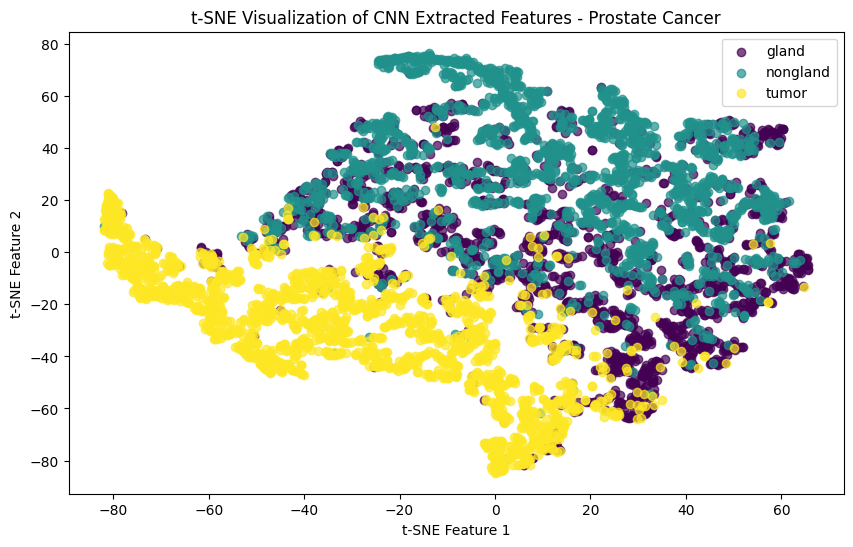

<ipython-input-63-c27509289f48>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', num_classes)


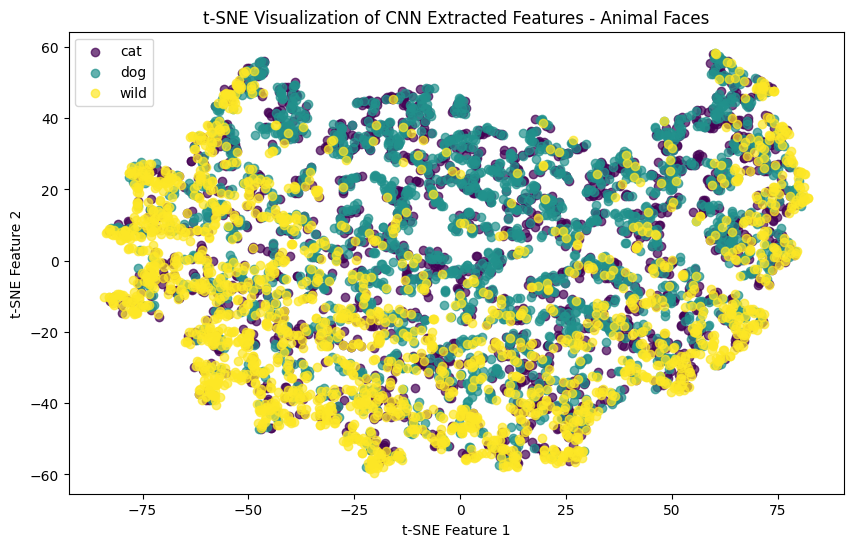

In [ ]:
# Plotting for Prostate Cancer dataset
plot_tsne(features_prostate_cancer, labels_prostate_cancer, dataset_name = "Prostate Cancer", label_mapping = {0: 'gland', 1: 'nongland', 2: 'tumor'})

# Plotting for Animal Faces dataset
plot_tsne(features_animal_faces, labels_animal_faces, dataset_name="Animal Faces", label_mapping = {0: 'cat', 1: 'dog', 2: 'wild'})

Plot t-SNE for the sample datasets

<ipython-input-9-b41d901302a1>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', num_classes)


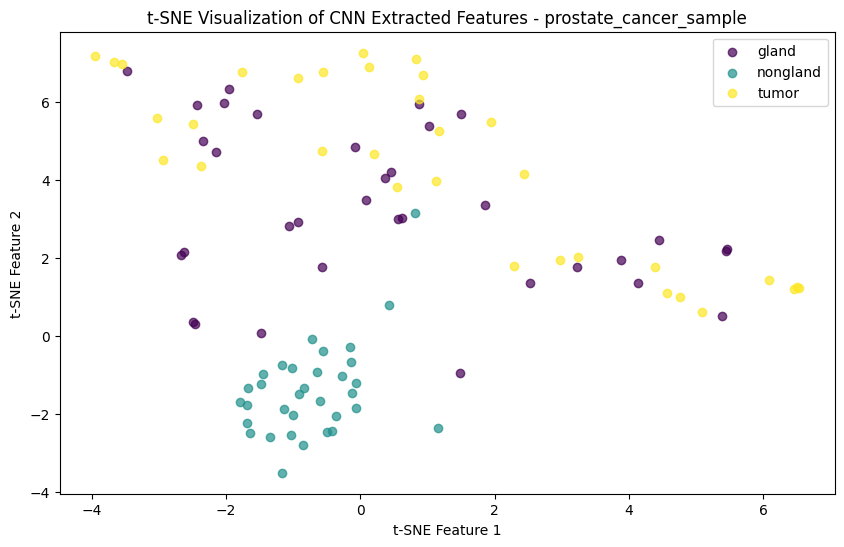

<ipython-input-9-b41d901302a1>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', num_classes)


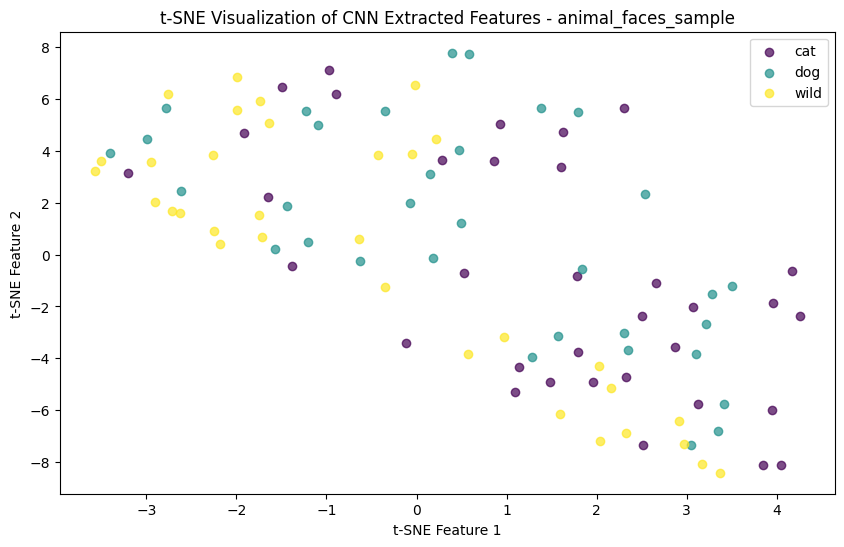

In [10]:
# Plotting for Prostate Cancer dataset sample
plot_tsne(features_prostate_cancer, labels_prostate_cancer, dataset_name = "prostate_cancer_sample", label_mapping = {0: 'gland', 1: 'nongland', 2: 'tumor'})

# Plotting for Animal Faces dataset sample
plot_tsne(features_animal_faces, labels_animal_faces, dataset_name="animal_faces_sample", label_mapping = {0: 'cat', 1: 'dog', 2: 'wild'})

For prostate cancer dataset using logistic regression:
Accuracy: 0.7666666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       1.00      1.00      1.00         7
           2       0.67      0.73      0.70        11

    accuracy                           0.77        30
   macro avg       0.80      0.80      0.80        30
weighted avg       0.77      0.77      0.77        30



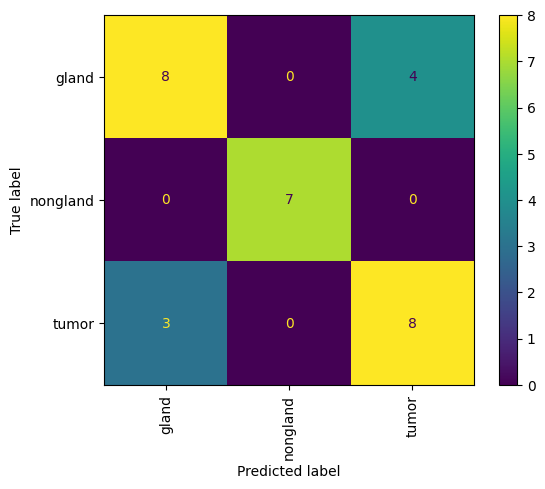

In [11]:
# Classification of extracted features for prostate cancer
X_train, X_test, y_train, y_test = train_test_split(features_prostate_cancer, labels_prostate_cancer, test_size=0.3, random_state=42)

# Train a Logistic Regression model
lr = LogisticRegression(penalty=None)
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Evaluate the classifier
print("For prostate cancer dataset using logistic regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

classes=['gland', 'nongland', 'tumor']

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=classes,
    cmap='viridis',
    xticks_rotation='vertical'
)

For animal faces dataset using SVM:
Accuracy: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.25      0.35        12
           1       0.40      0.57      0.47         7
           2       0.53      0.73      0.62        11

    accuracy                           0.50        30
   macro avg       0.51      0.52      0.48        30
weighted avg       0.53      0.50      0.48        30



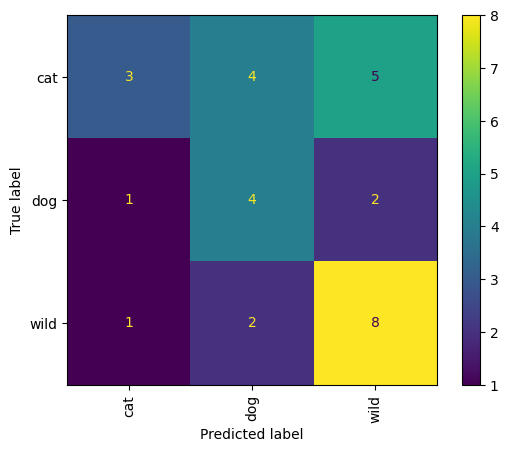

In [12]:
# Classification of extracted features for animal faces
X_train, X_test, y_train, y_test = train_test_split(features_animal_faces, labels_animal_faces, test_size=0.3, random_state=42)

# Create an SVM classifier
svm = SVC(kernel='linear')

# Train the SVM classifier
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)

# Evaluate the classifier
print("For animal faces dataset using SVM:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

classes=['cat', 'dog', 'wild']

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=classes,
    cmap='viridis',
    xticks_rotation='vertical'
)